## In this notebook, we are cleaning the 311 data from 2020-01-01 to 2021-03-31, so that we can better analyze the complaint type and evictions correlations.
## The analysis parts will be different notebooks

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data source:

file_path = '/content/drive/My Drive/X999/2023_2024_311.csv'

In [ ]:
# cleaning functions

# some cleaning ideas are from:
# https://www.kaggle.com/code/riyapatel1697/nyc-311-customer-service-requests-analysis

def drop_columns(df, columns):
    df.drop(columns, axis=1, inplace=True)

def clean_column_names(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.strip().str.replace(' ', '_')
    return df

# drop columns that are empty or almost empty
def drop_empty_columns(df):
    # drop columns that are completely or almost empty
    # and get the count of NaNs in each column
    na_col_count = df.isna().sum()
    columns_to_drop = []
    # use .items() instead of .iteritems()
    for column, na_count in na_col_count.items():
      # Check if the column has 85% or more NaNs
        if na_count / len(df) >= 0.85:
            columns_to_drop.append(column)

    df.drop(columns_to_drop, axis=1, inplace=True)  # Drop the columns
    return df

# def drop_unneccessary_columns(df):
#     #drop the unneccesary columns
#     cols = ['x_coordinate_(state_plane)',"agency_name", "agency",
#        'y_coordinate_(state_plane)', 'open_data_channel_type',
#        'park_facility_name', 'park_borough', 'vehicle_type', 'due_date',
#        'taxi_company_borough', 'taxi_pick_up_location', 'bridge_highway_name',
#        'bridge_highway_direction', 'road_ramp', 'bridge_highway_segment','resolution_action_updated_date']
#     df.drop(cols,axis=1,inplace=True)
#     return df

def drop_unneccessary_columns(df):
    columns_to_drop = ['x_coordinate_(state_plane)', 'agency_name', 'agency',
                       'y_coordinate_(state_plane)', 'open_data_channel_type',
                       'park_facility_name', 'park_borough', 'vehicle_type',
                       'due_date', 'taxi_company_borough', 'taxi_pick_up_location',
                       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
                       'bridge_highway_segment', 'facility_type', "community_board", "landmark"]

    # Drop the columns from the dataframe, only if they exist
    df_cleaned = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

    return df_cleaned


In [ ]:
complaints_df_raw = pd.read_csv(file_path)

In [ ]:
# complaints_df_raw["Complaint Type"].unique()

In [ ]:
complaints_df = complaints_df_raw.copy()

In [ ]:
complaints_df.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Complaint Type',
       'Descriptor', 'Location Type', 'Incident Zip', 'Incident Address',
       'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Status', 'Due Date', 'Resolution Description',
       'Resolution Action Updated Date', 'BBL', 'Borough', 'Latitude',
       'Longitude', 'Location', 'Zip Codes'],
      dtype='object')

In [ ]:
# make sure the column names are all lower case with hiphen, so that it would easier for cleaning
complaints_df = clean_column_names(complaints_df)

In [ ]:
# find complaint types that have something to do with noice or constructions
noise_construction_complaints = complaints_df[complaints_df['complaint_type'].str.contains(r'(?i)noise|construction', regex=True)]
noise_construction_complaints.complaint_type.unique()

array(['Noise - Residential', 'Noise - Street/Sidewalk',
       'Noise - Vehicle', 'Noise - Helicopter', 'Noise - Commercial',
       'General Construction/Plumbing', 'Noise', 'Noise - Park',
       'Noise - House of Worship', 'Construction Safety Enforcement'],
      dtype=object)

In [ ]:
# the type of complaints we want to keep: noise related
# AND we also want to keep the location type that is family residential related.
# so this is an OR situation, we keep them both here and do deeper cleaning later.

# following the last cell
noise_complaint_types = [
    'Noise - Residential', 'Noise - Helicopter', 'Noise - House of Worship', 'Noise - Commercial', 'Noise - Park',
    'Noise - Street/Sidewalk', 'Noise', 'Noise - Vehicle',
    'General Construction/Plumbing',
    'Collection Truck Noise', 'Construction Lead Dust',
    'COVID-19 Non-essential Construction',
    'Construction Safety Enforcement'
]
# particularly picked complaint types that tend to have stronger correlations between complaints and evictions.
must_include = [
    "Noise - Residential", "Unsanitary Condition", "Heat/Hot Water", "Flooring/Stairs", "Indoor Air Quality", "Smoking", "Door/Window",
    "Paint/Plaster", "Water Leak", "Electric", "Safety", "Plumbing", "Appliance", "Rodent", "Unsanitary Pigeon Condition", "Asbestos",
    "Elevator", "Construction Lead Dust", "Indoor Sewage", "Peeling Paint", "Window Guard", "Harboring Bees/Wasps", "Drinking Water",
    "Noise - Street/Sidewalk", "Mold"]

# filter rows where complaint_type is in the noise_complaint_types list or location_type contains the keywords
filtered_df = complaints_df[
    (complaints_df['complaint_type'].isin(noise_complaint_types)) |
     (complaints_df["complaint_type"].isin(must_include)) |
    (complaints_df['location_type'].str.contains(r'family|residential', case=False, na=False))
]

In [ ]:
# basic cleaning
filtered_df = drop_unneccessary_columns(filtered_df)
filtered_df = drop_empty_columns(filtered_df)

In [ ]:
filtered_df.complaint_type.unique(), len(filtered_df.complaint_type.unique())

(array(['WATER LEAK', 'HEAT/HOT WATER', 'UNSANITARY CONDITION',
        'Noise - Residential', 'Noise - Street/Sidewalk', 'Rodent',
        'Noise - Vehicle', 'Noise - Helicopter', 'Elevator',
        'Noise - Commercial', 'Smoking', 'General Construction/Plumbing',
        'DOOR/WINDOW', 'ELEVATOR', 'PAINT/PLASTER', 'Encampment',
        'PLUMBING', 'Animal-Abuse', 'ELECTRIC', 'GENERAL', 'Noise',
        'Non-Emergency Police Matter', 'Noise - Park', 'FLOORING/STAIRS',
        'Indoor Air Quality', 'Illegal Fireworks', 'Graffiti', 'SAFETY',
        'APPLIANCE', 'Homeless Person Assistance', 'Urinating in Public',
        'Non-Residential Heat', 'Mold', 'Unsanitary Animal Pvt Property',
        'Drinking', 'Unsanitary Pigeon Condition', 'Asbestos', 'Plumbing',
        'Drinking Water', 'OUTSIDE BUILDING', 'Noise - House of Worship',
        'Indoor Sewage', 'Panhandling', 'Disorderly Youth',
        'Posting Advertisement', 'Bike/Roller/Skate Chronic',
        'Construction Safety Enfo

In [ ]:
filtered_df.location_type.unique()

array(['RESIDENTIAL BUILDING', 'Residential Building/House',
       'Street/Sidewalk', '3+ Family Apt. Building', 'Above Address', nan,
       'Store/Commercial', 'Residential Building', 'Construction Site',
       'Park/Playground', '3+ Family Mixed Use Building',
       'Catch Basin/Sewer', 'Residential', 'Club/Bar/Restaurant',
       'Other (Explain Below)', '1-2 Family Dwelling',
       'Restaurant/Bar/Deli/Bakery', 'Commercial Building',
       'Building (Non-Residential)', 'Loft Residence',
       '3+ Family Apartment Building', 'Public Garden',
       '1-2 Family Mixed Use Building', 'Vacant Lot', 'House of Worship',
       'Loft Building - Common Areas', 'Vacant Building',
       'Parking Lot/Garage', 'Hospital', 'Homeless Shelter', 'Theater',
       'School/Pre-School', 'Day Care/Nursery',
       'Single Room Occupancy (SRO)', 'Office Building', 'Other',
       'Restaurant', '1-3 Family Dwelling', 'Government Building',
       'Airport or Train/Bus Station', 'Retail Store',
  

In [ ]:
filtered_df.shape, \
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2587588 entries, 3 to 5411562
Data columns (total 24 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   unique_key                      int64  
 1   created_date                    object 
 2   closed_date                     object 
 3   complaint_type                  object 
 4   descriptor                      object 
 5   location_type                   object 
 6   incident_zip                    object 
 7   incident_address                object 
 8   street_name                     object 
 9   cross_street_1                  object 
 10  cross_street_2                  object 
 11  intersection_street_1           object 
 12  intersection_street_2           object 
 13  address_type                    object 
 14  city                            object 
 15  status                          object 
 16  resolution_description          object 
 17  resolution_action_updated_date  

((2587588, 24), None)

In [ ]:
filtered_df.head(2)

,unique_key,created_date,closed_date,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,...,city,status,resolution_description,resolution_action_updated_date,bbl,borough,latitude,longitude,location,zip_codes
3,56413440,01/01/2023 02:49:28 PM,01/05/2023 09:33:33 AM,WATER LEAK,SLOW LEAK,RESIDENTIAL BUILDING,10462.0,2075 ST RAYMONDS AVENUE,ST RAYMONDS AVENUE,NaN,...,BRONX,Closed,The Department of Housing Preservation and Dev...,01/05/2023 12:00:00 AM,2.039438e+09,BRONX,40.837510,-73.855086,"(40.83751009555891, -73.85508590936654)",11271.0
4,56413106,01/01/2023 02:49:32 PM,01/03/2023 03:45:17 PM,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10462.0,2055 CRUGER AVENUE,CRUGER AVENUE,NaN,...,BRONX,Closed,The Department of Housing Preservation and Dev...,01/03/2023 12:00:00 AM,2.042840e+09,BRONX,40.851882,-73.866784,"(40.85188177753733, -73.86678427219233)",11271.0


In [ ]:
filtered_df.complaint_type.unique(), len(filtered_df.complaint_type.unique())

(array(['WATER LEAK', 'HEAT/HOT WATER', 'UNSANITARY CONDITION',
        'Noise - Residential', 'Noise - Street/Sidewalk', 'Rodent',
        'Noise - Vehicle', 'Noise - Helicopter', 'Elevator',
        'Noise - Commercial', 'Smoking', 'General Construction/Plumbing',
        'DOOR/WINDOW', 'ELEVATOR', 'PAINT/PLASTER', 'Encampment',
        'PLUMBING', 'Animal-Abuse', 'ELECTRIC', 'GENERAL', 'Noise',
        'Non-Emergency Police Matter', 'Noise - Park', 'FLOORING/STAIRS',
        'Indoor Air Quality', 'Illegal Fireworks', 'Graffiti', 'SAFETY',
        'APPLIANCE', 'Homeless Person Assistance', 'Urinating in Public',
        'Non-Residential Heat', 'Mold', 'Unsanitary Animal Pvt Property',
        'Drinking', 'Unsanitary Pigeon Condition', 'Asbestos', 'Plumbing',
        'Drinking Water', 'OUTSIDE BUILDING', 'Noise - House of Worship',
        'Indoor Sewage', 'Panhandling', 'Disorderly Youth',
        'Posting Advertisement', 'Bike/Roller/Skate Chronic',
        'Construction Safety Enfo

In [ ]:
# # particularly filter out the complaint type that is Covid-19 Non essential Construction
# filtered_df_covid = filtered_df[filtered_df['complaint_type'] == 'COVID-19 Non-essential Construction']
# filtered_df_covid.shape, \
# filtered_df_covid.info()

In [ ]:
filtered_df.isna().sum().where(lambda x:x>0).dropna()

,0
descriptor,23214.0
location_type,197281.0
incident_zip,1305.0
incident_address,10144.0
street_name,10176.0
cross_street_1,1261218.0
cross_street_2,1260762.0
intersection_street_1,1334292.0
intersection_street_2,1333811.0
address_type,573.0


In [ ]:
filtered_df = filtered_df.dropna(subset=['bbl'])
filtered_df.shape

(2473148, 24)

In [ ]:
# filtered_df_covid = filtered_df_covid.dropna(subset=['bbl'])
# filtered_df_covid.shape

In [ ]:
# convert to datetime
filtered_df.created_date =  pd.to_datetime(filtered_df.created_date)
filtered_df.closed_date =  pd.to_datetime(filtered_df.closed_date)

In [ ]:
# filtered_df_covid.created_date = pd.to_datetime(filtered_df_covid.created_date)
# filtered_df_covid.closed_date = pd.to_datetime(filtered_df_covid.closed_date)

In [ ]:
filtered_df.created_date.min(), filtered_df.created_date.max(), \
filtered_df.closed_date.min(), filtered_df.closed_date.max()

(Timestamp('2023-01-01 14:49:28'),
 Timestamp('2024-09-20 01:33:18'),
 Timestamp('2023-01-01 15:18:12'),
 Timestamp('2024-09-20 02:22:23'))

In [ ]:
# filtered_df_covid.created_date.min(), filtered_df_covid.created_date.max(), \
# filtered_df_covid.closed_date.min(), filtered_df_covid.closed_date.max()

In [ ]:
# since we particularly have an interest in "Non-Essentail Covid Consturction noise" that was only
# present during covid, we particularly set the timeframe as 2020-03-15 to 2021-03-31
# filtered_df = filtered_df[filtered_df['created_date'] > pd.Timestamp('2020-03-15 00:00:00')]
# filtered_df_covid = filtered_df_covid[filtered_df_covid['created_date'] > pd.Timestamp('2020-03-15 00:00:00')]

In [ ]:
# filtered_df.loc[filtered_df.status.isin(['open','assigned','draft']),'status'] = 'closed'
# filtered_df_covid.loc[filtered_df_covid.status.isin(['open','assigned','draft']),'status'] = 'closed'

In [ ]:
# cleaning idea: https://www.kaggle.com/code/riyapatel1697/nyc-311-customer-service-requests-analysis
city = filtered_df.city.mode()[0]
zipcode = filtered_df.loc[filtered_df.city == city,'incident_zip'].mode()[0]
latitude = filtered_df.loc[filtered_df['incident_zip'] == zipcode,'latitude'].mode()[0]
longitude = filtered_df.loc[filtered_df['incident_zip'] == zipcode,'longitude'].mode()[0]
#fill zipcode,latitude and longitude with modevalues where city is empty and then update city value to mode value
filtered_df.loc[filtered_df.city.isna(),'incident_zip'] = zipcode
filtered_df.loc[filtered_df.city.isna(),'city'] = city
filtered_df.loc[(filtered_df.city == city) & (filtered_df.latitude.isna()==True),'latitude'] = latitude
filtered_df.loc[(filtered_df.city == city) & (filtered_df.longitude.isna()==True),'longitude'] = longitude

In [ ]:
# city = filtered_df_covid.city.mode()[0]
# zipcode = filtered_df_covid.loc[filtered_df_covid.city == city,'incident_zip'].mode()[0]
# latitude = filtered_df_covid.loc[filtered_df_covid['incident_zip'] == zipcode,'latitude'].mode()[0]
# longitude = filtered_df_covid.loc[filtered_df_covid['incident_zip'] == zipcode,'longitude'].mode()[0]
# #fill zipcode,latitude and longitude with modevalues where city is empty and then update city value to mode value
# filtered_df_covid.loc[filtered_df_covid.city.isna(),'incident_zip'] = zipcode
# filtered_df_covid.loc[filtered_df_covid.city.isna(),'city'] = city
# filtered_df_covid.loc[(filtered_df_covid.city == city) & (filtered_df_covid.latitude.isna()==True),'latitude'] = latitude
# filtered_df_covid.loc[(filtered_df_covid.city == city) & (filtered_df_covid.longitude.isna()==True),'longitude'] = longitude

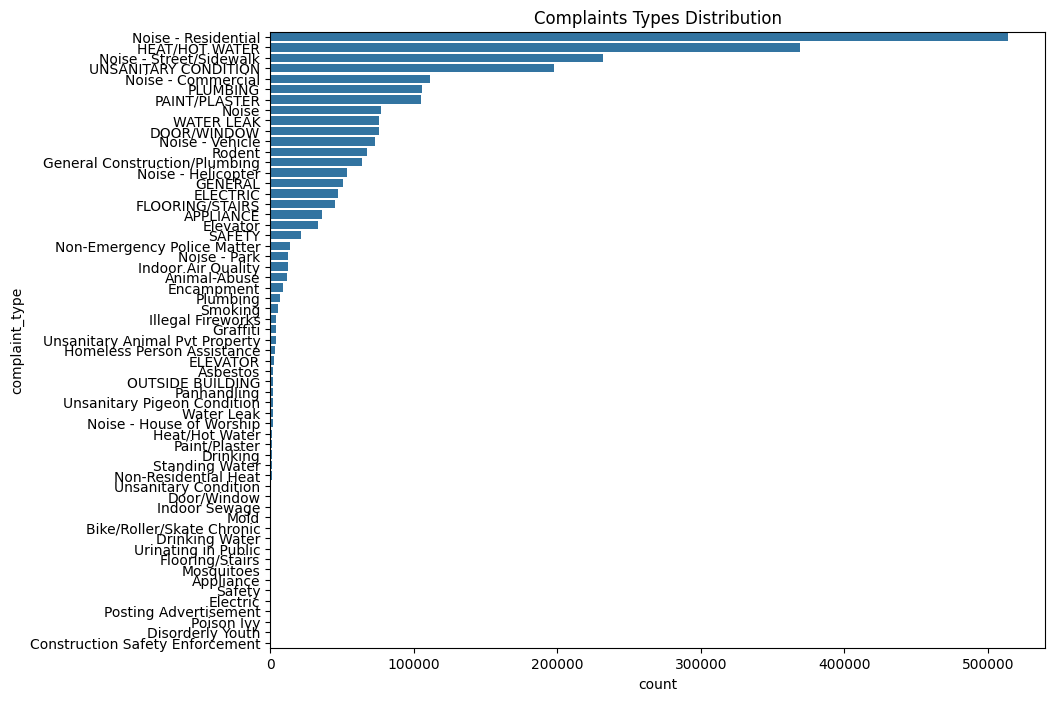

In [ ]:
complaint_order = filtered_df['complaint_type'].value_counts().index
plt.figure(figsize=(10,8))
plt.title('Complaints Types Distribution')
sns.countplot(y='complaint_type', data=filtered_df, order=complaint_order)
plt.show()

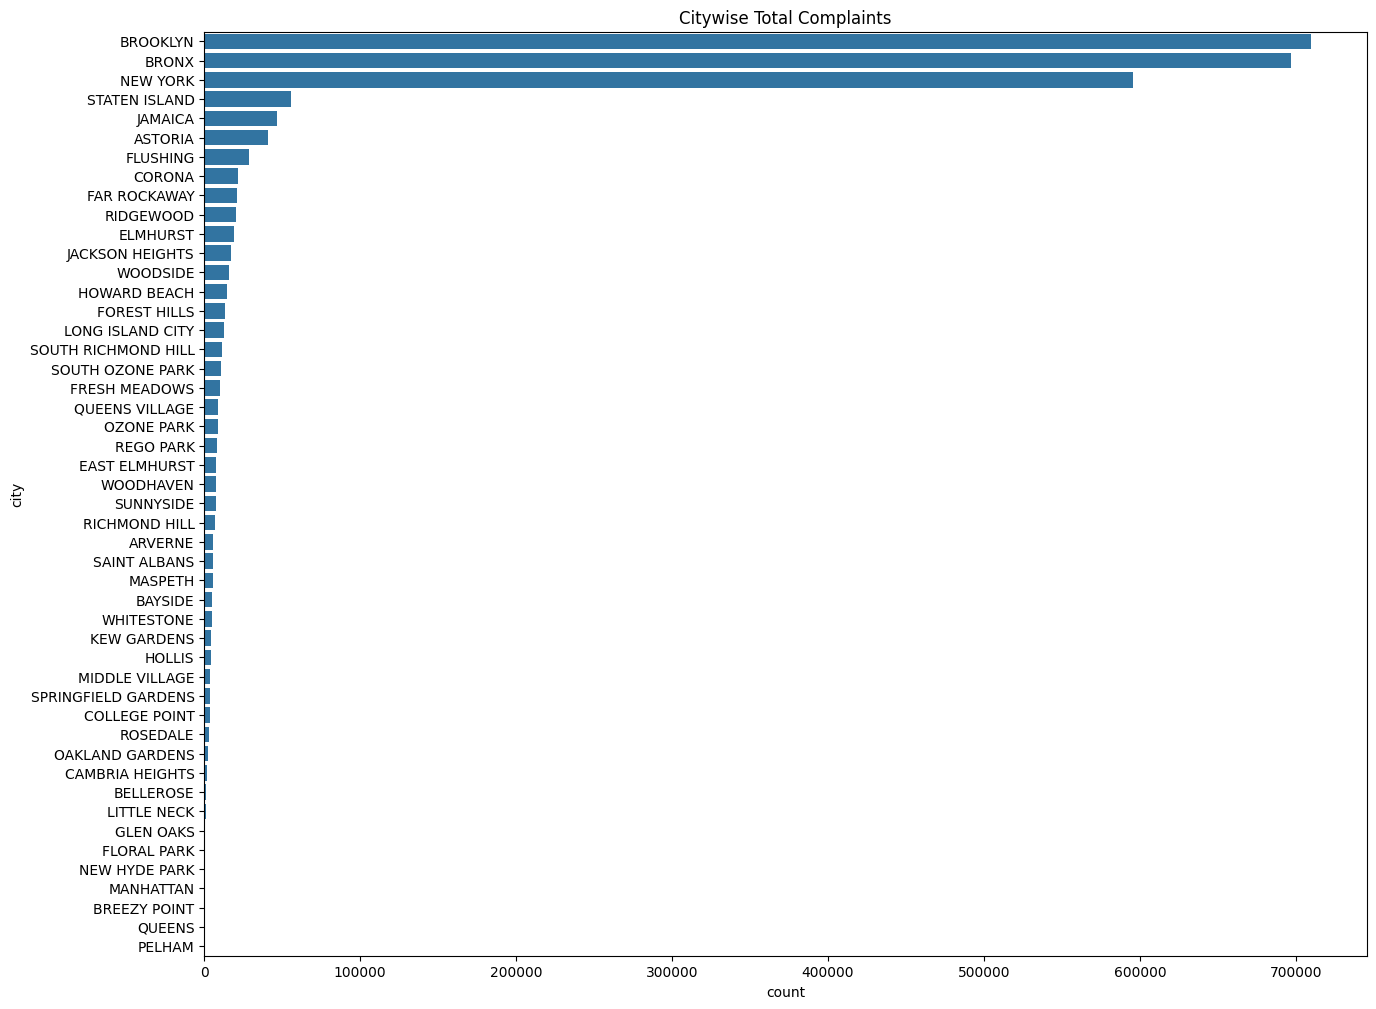

In [ ]:
city_order = filtered_df['city'].value_counts().index
plt.figure(figsize=(15,12))
plt.title('Citywise Total Complaints')
sns.countplot(y='city', data=filtered_df, order=city_order)
plt.show()

In [ ]:
# # save cleaned 2020-03-15 to 2021-03-31 complaints data to my drive
# filtered_df.to_csv('/content/drive/My Drive/X999/filtered_df_covid_period_all.csv', index=False)

In [ ]:
# # save cleaned 2020-03-15 to 2021-03-31 only "non essential covid construction noise" complaints data to my drive
# filtered_df_covid.to_csv('/content/drive/My Drive/X999/filtered_df_covid.csv', index=False)

In [ ]:
# save cleaned 2020-03-15 to 2021-03-31 complaints data to my drive
filtered_df.to_csv('/content/drive/My Drive/X999/filtered_df_2023_2024.csv', index=False)